In [87]:
!pip install pandas numpy matplotlib scikit-learn xgboost tensorflow


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers


In [92]:
df = pd.read_csv("sample_data.csv", parse_dates=["date"], index_col="date")
df = df.asfreq("D")     # daily frequency

print(df.head())
print(df.tail())
print(df.shape)


                 value
date                  
2025-01-01  102.483571
2025-01-02  107.401719
2025-01-03  113.537172
2025-01-04  112.778162
2025-01-05   95.589297
                 value
date                  
2025-12-27  205.836669
2025-12-28  202.500681
2025-12-29  189.157470
2025-12-30  193.915519
2025-12-31  203.450720
(365, 1)


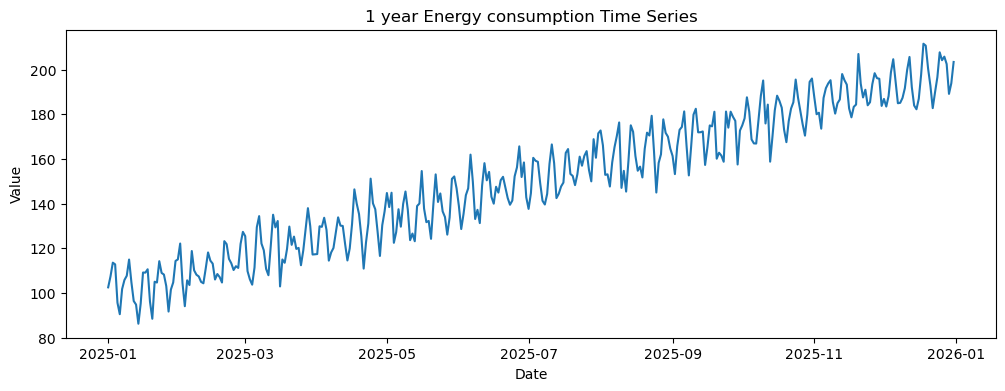

In [93]:
plt.figure(figsize=(12,4))
plt.plot(df.index, df["value"])
plt.title("1 year Energy consumption Time Series")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()


In [94]:
HORIZON = 7  # predict 7 days into the future

def create_features(df, horizon=7):
    df_feat = df.copy()

    # Lag features (previous 30 days)
    for lag in range(1, 31):
        df_feat[f"lag_{lag}"] = df_feat["value"].shift(lag)

    # Rolling statistics
    df_feat["roll_mean_7"] = df_feat["value"].shift(1).rolling(7).mean()
    df_feat["roll_mean_30"] = df_feat["value"].shift(1).rolling(30).mean()
    df_feat["roll_std_7"]  = df_feat["value"].shift(1).rolling(7).std()

    # Calendar features
    df_feat["day"] = df_feat.index.day
    df_feat["month"] = df_feat.index.month
    df_feat["weekday"] = df_feat.index.weekday

    # Target: value HORIZON days ahead
    df_feat["target"] = df_feat["value"].shift(-horizon)

    return df_feat

df_feat = create_features(df, HORIZON)
df_feat = df_feat.dropna()
df_feat.head()


,value,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_28,lag_29,lag_30,roll_mean_7,roll_mean_30,roll_std_7,day,month,weekday,target
date,,,,,,,,,,,,,,,,,,,,,
2025-01-31,114.982504,114.326879,104.689114,101.477758,91.638610,103.083907,108.210330,108.944220,114.199912,104.640349,...,113.537172,107.401719,102.483571,104.624403,103.303392,7.148044,31,1,4,110.115764
2025-02-01,122.116712,114.982504,114.326879,104.689114,101.477758,91.638610,103.083907,108.210330,108.944220,114.199912,...,112.778162,113.537172,107.401719,105.487015,103.720024,8.062134,1,2,5,108.137468
2025-02-02,104.384885,122.116712,114.982504,114.326879,104.689114,101.477758,91.638610,103.083907,108.210330,108.944220,...,95.589297,112.778162,113.537172,107.473641,104.210523,10.259074,2,2,6,107.359755
2025-02-03,94.028100,104.384885,122.116712,114.982504,114.326879,104.689114,101.477758,91.638610,103.083907,108.210330,...,90.453662,95.589297,112.778162,107.659495,103.905447,10.177757,3,2,0,104.932065
2025-02-04,105.635069,94.028100,104.384885,122.116712,114.982504,114.326879,104.689114,101.477758,91.638610,103.083907,...,101.726101,90.453662,95.589297,108.000850,103.280445,9.572974,4,2,1,104.302263


In [95]:
train_size = int(len(df_feat) * 0.8)

train = df_feat.iloc[:train_size]
test  = df_feat.iloc[train_size:]

X_train = train.drop(columns=["target"])
y_train = train["target"]

X_test = test.drop(columns=["target"])
y_test = test["target"]

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)



Train shape: (262, 37)
Test shape : (66, 37)


In [96]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

n_features = X_train_scaled.shape[1]
print("Number of features:", n_features)




Number of features: 37


In [97]:
model_xgb = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_xgb.fit(X_train_scaled, y_train)
pred_xgb = model_xgb.predict(X_test_scaled)

mae_xgb = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))

print(f"XGBoost MAE : {mae_xgb:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.4f}")


XGBoost MAE : 7.4118
XGBoost RMSE: 9.9718


In [98]:
values = df["value"].values.reshape(-1, 1)
scaler_val = StandardScaler()
values_scaled = scaler_val.fit_transform(values)


In [99]:
def create_value_sequences(values, timesteps=30):
    X, y = [], []
    for i in range(len(values) - timesteps):
        X.append(values[i:i+timesteps])
        y.append(values[i+timesteps])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_value_sequences(values_scaled, TIMESTEPS)


In [111]:
df_feat_clean = df_feat.dropna().copy()  # VERY IMPORTANT

train_size = int(len(df_feat_clean) * 0.8)
train = df_feat_clean.iloc[:train_size]
test  = df_feat_clean.iloc[train_size:]



In [112]:
TIMESTEPS = 30
n_features = train.drop(columns=['target']).shape[1]

X_lstm_train, y_lstm_train = create_lstm_sequences_df(train, TIMESTEPS)
X_lstm_test,  y_lstm_test  = create_lstm_sequences_df(test, TIMESTEPS)

print("LSTM train:", X_lstm_train.shape, y_lstm_train.shape)
print("LSTM test :", X_lstm_test.shape,  y_lstm_test.shape)


LSTM train: (232, 30, 37) (232,)
LSTM test : (36, 30, 37) (36,)


In [113]:
model_lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(TIMESTEPS, n_features)),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 64)             │        26,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,225 (110.25 KB)

 Trainable params: 28,225 (110.25 KB)

 Non-trainable params: 0 (0.00 B)

In [114]:
history = model_lstm.fit(
    X_lstm_train, y_lstm_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)



Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 20628.6914 - val_loss: 30305.3184
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 20359.7520 - val_loss: 30144.9785
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 20237.4258 - val_loss: 29992.6855
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 20098.2441 - val_loss: 29790.5820
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 19928.9316 - val_loss: 29583.4727
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 19764.5879 - val_loss: 29382.8184
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 19597.1465 - val_loss: 29168.4902
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 19418.8047 - val_loss: 28942.3145
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 19231.8203 - val_loss: 28704.1055
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 19034.9824 - val_loss: 28456.8145
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 18830.8926 - val_loss: 28196.05

In [115]:
print(f"LSTM MAE : {mae_lstm:.4f}") 
print(f"LSTM RMSE: {rmse_lstm:.4f}")

LSTM MAE : 0.7014
LSTM RMSE: 0.7577


In [116]:
pred_lstm = model_lstm.predict(X_lstm_test).flatten()

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_lstm = mean_absolute_error(y_lstm_test, pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_lstm_test, pred_lstm))

print("LSTM MAE :", mae_lstm)
print("LSTM RMSE:", rmse_lstm)



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
LSTM MAE : 122.70275851762332
LSTM RMSE: 122.98897784650775


In [117]:
test.index[TIMESTEPS:]


DatetimeIndex(['2025-11-19', '2025-11-20', '2025-11-21', '2025-11-22',
               '2025-11-23', '2025-11-24', '2025-11-25', '2025-11-26',
               '2025-11-27', '2025-11-28', '2025-11-29', '2025-11-30',
               '2025-12-01', '2025-12-02', '2025-12-03', '2025-12-04',
               '2025-12-05', '2025-12-06', '2025-12-07', '2025-12-08',
               '2025-12-09', '2025-12-10', '2025-12-11', '2025-12-12',
               '2025-12-13', '2025-12-14', '2025-12-15', '2025-12-16',
               '2025-12-17', '2025-12-18', '2025-12-19', '2025-12-20',
               '2025-12-21', '2025-12-22', '2025-12-23', '2025-12-24'],
              dtype='datetime64[ns]', name='date', freq='D')

In [118]:
lstm_dates = test.index[TIMESTEPS:]


In [119]:
print(len(lstm_dates), len(y_lstm_test), len(pred_lstm))


36 36 36


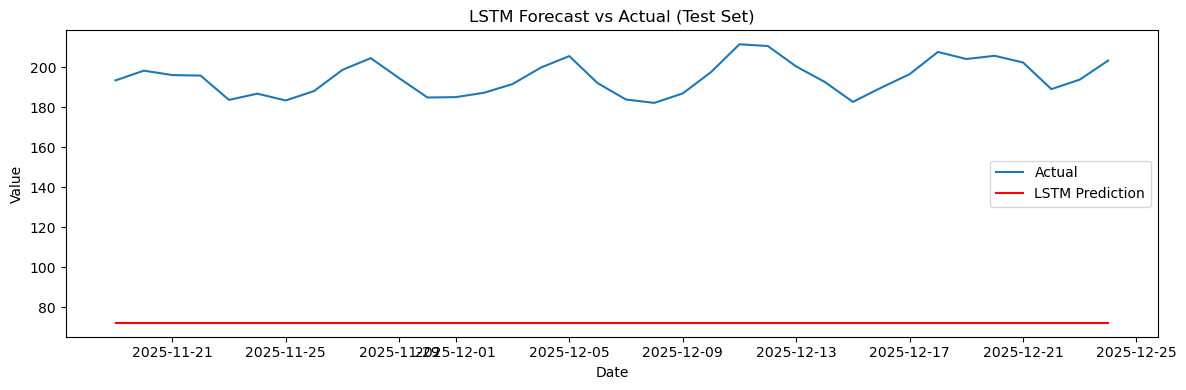

In [120]:
plt.figure(figsize=(12,4))
plt.plot(lstm_dates, y_lstm_test, label="Actual")
plt.plot(lstm_dates, pred_lstm, label="LSTM Prediction", color="red")
plt.title("LSTM Forecast vs Actual (Test Set)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()


In [63]:
def forecast_next_days(model, df, steps, timesteps=30):
    df_future = df.copy()

    for i in range(steps):
        # Create features fresh for the entire df
        df_feat_temp = create_features(df_future)

        # Keep only the rows with full feature availability
        df_feat_temp = df_feat_temp.dropna()

        # Select last 'timesteps' rows
        X_last = df_feat_temp.drop(columns=["target"]).values[-timesteps:]

        # Reshape for LSTM
        X_input = X_last.reshape(1, timesteps, X_last.shape[1])

        # Predict next value
        next_val = model.predict(X_input, verbose=0)[0][0]

        # Append predicted value as new row
        next_date = df_future.index[-1] + pd.Timedelta(days=1)
        df_future.loc[next_date] = [next_val]

    return df_future[-steps:]


In [64]:
forecast_df = forecast_next_days(model_lstm, df, 30, timesteps=TIMESTEPS)
forecast_df



,value
date,
2026-01-01,51.703888
2026-01-02,51.703888
2026-01-03,51.703888
2026-01-04,51.703888
2026-01-05,51.703888
2026-01-06,51.703888
2026-01-07,51.703888
2026-01-08,51.703888
2026-01-09,51.703888


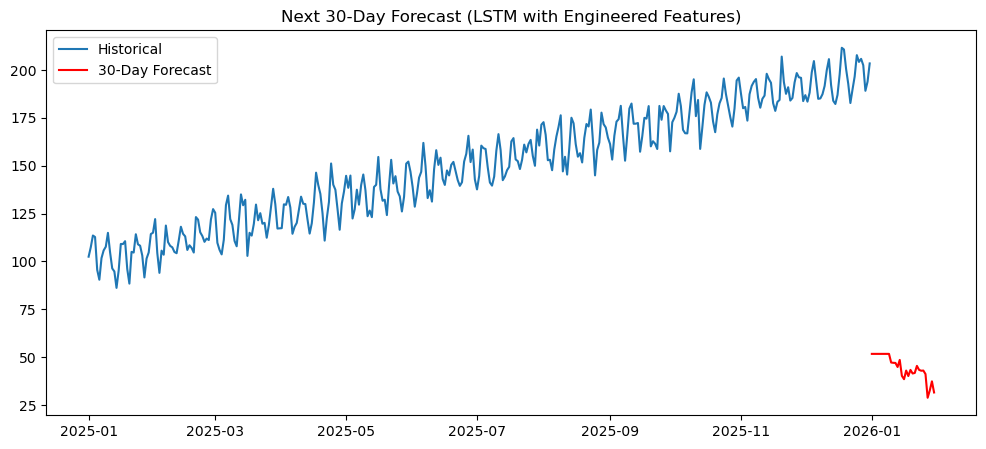

In [65]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df["value"], label="Historical")
plt.plot(forecast_df.index, forecast_df.values, label="30-Day Forecast", color="red")
plt.title("Next 30-Day Forecast (LSTM with Engineered Features)")
plt.legend()
plt.show()

